In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.pipeline
import sklearn.neighbors
import re
import os
import textwrap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [3]:
#load data 
data_dir = '/Users/mengyao/Documents/CS135_IntroToML/cs135-25f-assignments/projectA/data_readinglevel'

if __name__ == '__main__':
    # data_dir = 'data_readinglevel'
    x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv')).sample(frac=1, random_state=42).reset_index(drop=True)
    y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv')).sample(frac=1, random_state=42).reset_index(drop=True)

    N, n_cols = x_train_df.shape
    print("Shape of x_train_df: (%d, %d)" % (N, n_cols))
    print("Shape of y_train_df: %s" % str(y_train_df.shape))

    # Print out 8 random entries
    tr_text_list = x_train_df['text'].values.tolist()
    prng = np.random.RandomState(101)
    rows = prng.permutation(np.arange(y_train_df.shape[0]))
    for row_id in rows[:8]:
        text = tr_text_list[row_id]
        print("row %5d | %s BY %s | y = %s" % (
            row_id,
            y_train_df['title'].values[row_id],
            y_train_df['author'].values[row_id],
            y_train_df['Coarse Label'].values[row_id],
            ))
        # Pretty print text via textwrap library
        line_list = textwrap.wrap(tr_text_list[row_id],
            width=70,
            initial_indent='  ',
            subsequent_indent='  ')
        print('\n'.join(line_list))
        print("")

Shape of x_train_df: (5557, 32)
Shape of y_train_df: (5557, 5)
row  4746 | Martin Eden BY Jack London | y = Key Stage 4-5
  When he left the car, he strode along the sidewalk as a wrathful man
  will stride, and he rang the Morse bell with such viciousness that
  it  roused him to consciousness of his condition, so that he entered
  in  good nature, smiling with amusement at himself. No sooner,
  however, was  he inside than a great depression descended upon him.
  He fell from the  height where he had been up-borne all day on the
  wings of inspiration. "Bourgeois," "trader's den"—Brissenden's
  epithets repeated themselves  in his mind.

row  1250 | The Scarlet Pimpernel BY Baroness Emmuska Orczy Orczy | y = Key Stage 4-5
  Marguerite would redeem her  brother's life at the hands of the
  relentless enemy, then let that  cunning Scarlet Pimpernel extricate
  himself after that. Perhaps—vaguely—Marguerite hoped that the daring
  plotter, who for so  many months had baffled an army of 

In [4]:
x_train_df.head()

,author,title,passage_id,text,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,type_token_ratio,...,readability_RIX,readability_DaleChallIndex,info_characters_per_word,info_syll_per_word,info_words_per_sentence,info_type_token_ratio,info_characters,info_syllables,info_words,info_wordtypes
0,Thomas Hughes,Tom Brown's School Days,5678,"They also cheered him, as he was no longer un...",388.0,84.0,3.0,3.714286,28.000000,0.750000,...,11.0,10.497283,4.166667,1.222222,72.0,0.847222,300.0,88.0,72.0,61.0
1,Thomas Hughes,Tom Brown's School Days,930,If the chickens were dead and lying in a shop...,476.0,100.0,3.0,3.870000,33.333333,0.720000,...,13.0,11.599215,4.168539,1.191011,89.0,0.775281,371.0,106.0,89.0,69.0
2,René Descartes,Discourse on the Method of Rightly Conducting ...,4195,"This method, from the time I had begun to app...",447.0,88.0,1.0,4.090909,88.000000,0.715909,...,15.0,11.747804,4.358025,1.395062,81.0,0.740741,353.0,113.0,81.0,60.0
3,Andrew Lang,The Violet Fairy Book,3211,The gazelle kept silence for a few moments. Th...,382.0,89.0,4.0,3.426966,22.250000,0.640449,...,7.0,9.461833,3.840000,1.080000,75.0,0.680000,288.0,81.0,75.0,51.0
4,E. Nesbit,The Railway Children,5471,The very sleepers on which the rails lay were ...,502.0,106.0,4.0,3.820755,26.500000,0.688679,...,17.0,11.289048,4.271739,1.282609,92.0,0.750000,393.0,118.0,92.0,69.0


In [5]:
def expand_contractions(text):
    contractions = {
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }
    for key, value in contractions.items():
        text = text.replace(key, value)
    return text

In [6]:
def tokenize_text(raw_text):
    ''' Transform a plain-text string into a list of tokens
    
    We assume that *whitespace* divides tokens.
    
    Args
    ----
    raw_text : string
    
    Returns
    -------
    list_of_tokens : list of strings
        Each element is one token in the provided text

    '''
    
    list_of_tokens = raw_text.split() # split method divides on whitespace by default
    for pp in range(len(list_of_tokens)):
        cur_token = list_of_tokens[pp]
        # Remove punctuation
        for punc in ['?', '!', '_', '.', ',', '"', '/']:
            cur_token = cur_token.replace(punc, "")
        
        clean_token=expand_contractions(cur_token.lower())# Turn to lower case
        clean_token=re.sub(r'\d+', '', clean_token)  # Remove numbers
        # celan_token = re.sub(r'\s+', '', clean_token)  # Remove extra whitespace
        # Replace the cleaned token into the original list
        list_of_tokens[pp] = clean_token
    return list_of_tokens

In [7]:
#Turn text into a list of tokens
for i in range(5557):
    review_text=x_train_df['text'].iloc[i]
    tokens=tokenize_text(review_text)
    print(f"clean token list {i}: {tokens[:5]}...")  # Print first

clean token list 0: ['they', 'also', 'cheered', 'him', 'as']...
clean token list 1: ['if', 'the', 'chickens', 'were', 'dead']...
clean token list 2: ['this', 'method', 'from', 'the', 'time']...
clean token list 3: ['the', 'gazelle', 'kept', 'silence', 'for']...
clean token list 4: ['the', 'very', 'sleepers', 'on', 'which']...
clean token list 5: ['i', 'have', 'a', 'presentiment', 'on']...
clean token list 6: ['the', 'fierceness', 'of', 'this', 'creature is']...
clean token list 7: ['to', 'prevent', 'peter', 'ordering', 'babies']...
clean token list 8: ['moreover', 'he', 'was', 'democratic', 'in']...
clean token list 9: ['when', 'she', 'had', 'spoken', 'these']...
clean token list 10: ['education', 'of', 'these', 'accidental', 'causes']...
clean token list 11: ['their', 'common', 'superior', 'so', 'far']...
clean token list 12: ['he', 'turned', 'and', 'tottered', 'towards']...
clean token list 13: ['the', 'general', 'too', 'was', 'highly']...
clean token list 14: ['my', 'master', 'and',

In [8]:
tok_count_dict = dict()
for i in range(5557):
    review_text=x_train_df['text'].iloc[i]
    tokens=tokenize_text(review_text)
    for token in tokens:
        if token in tok_count_dict:
            tok_count_dict[token] += 1
        else:
            tok_count_dict[token] = 1

In [9]:
sorted_tokens = list(sorted(tok_count_dict, key=tok_count_dict.get, reverse=True))

In [10]:
#15 most common tokens
for w in sorted_tokens[:10]:
    print("%5d %s" % (tok_count_dict[w], w))

24173 the
14483 and
12029 of
11903 to
 9227 a
 6778 in
 6728 i
 5982 he
 5501 that
 5258 was


In [11]:

# custom = sorted({'the','and','of','to','a','in','i','he','that','was'})

In [12]:
#15 least common tokens/words
for w in sorted_tokens[-15:]:
    print("%5d %s" % (tok_count_dict[w], w))

    1 nathaniel is
    1 gabriel is
    1 unpink would
    1 heel;
    1 sheathing;
    1 gregory;
    1 beggarly;
    1 rascals
    1 servants]
    1 those—
    1 blaspheme
    1 atheistically
    1 inflicting
    1 desolating
    1 stroke;


In [13]:
# Create a list of strings that identify all tokens in our vocabulary
# We'll use a *list comprehension*, a way in Python to cleaning select a subset of a larger list
# by providing an if statement.

vocab_list = [w for w in sorted_tokens if tok_count_dict[w] >= 4]

In [14]:
for w in vocab_list:
    print("%5d %s" % (tok_count_dict[w], w))

24173 the
14483 and
12029 of
11903 to
 9227 a
 6778 in
 6728 i
 5982 he
 5501 that
 5258 was
 4864 it
 4379 his
 3714 you
 3549 with
 3400 had
 3341 as
 3285 for
 3203 her
 3044 she
 2797 but
 2780 not
 2676 is
 2629 on
 2590 at
 2412 be
 2296 him
 2208 my
 2168 they
 1993 have
 1931 said
 1838 all
 1836 this
 1828 by
 1781 from
 1776 me
 1754 which
 1718 so
 1614 were
 1434 one
 1392 would
 1364 we
 1352 what
 1336 there
 1301 if
 1280 or
 1268 no
 1241 when
 1185 them
 1184 their
 1157 are
 1116 who
 1112 then
 1106 out
 1105 an
 1088 up
 1015 will
  962 been
  951 now
  939 could
  924 do
  885 more
  838 into
  825 some
  824 little
  812 like
  803 your
  799 very
  788 man
  786 
  757 did
  750 time
  734 about
  718 see
  685 upon
  643 know
  637 down
  632 other
  627 than
  620 any
  602 only
  595 before
  592 well
  591 our
  591 us
  589 good
  583 how
  578 over
  573 never
  562 go
  553 come
  549 made
  538 much
  537 after
  534 came
  524 has
  523 just
  520 should

In [15]:
print(f"The number of words in the Vocabulary List is {len(vocab_list)}")

vocab_list_larger = [w for w in sorted_tokens if tok_count_dict[w] >= 2]

print(f"The number of words in the Vocabulary List with count at least 2 is {len(vocab_list_larger)}")

The number of words in the Vocabulary List is 8083
The number of words in the Vocabulary List with count at least 2 is 15106


In [16]:
vocab_dict = dict()
for vocab_id, tok in enumerate(vocab_list):
    vocab_dict[tok] = vocab_id


def transform_text_into_feature_vector(text, vocab_dict):
    ''' Produce count feature vector for provided text
    
    Args
    ----
    text : string
        A string of raw text, representing a single 'review'
    vocab_dict : dict with string keys
        If token is in vocabulary, will exist as key in the dict
        If token is not in vocabulary, will not be in the dict

    Returns
    -------
    count_V : 1D numpy array, shape (V,) = (n_vocab,)
        Count vector, indicating how often each vocab word
        appears in the provided text string
    '''
    V = len(vocab_dict.keys())
    count_V = np.zeros(V)
    for tok in tokenize_text(text):
        if tok in vocab_dict:
            vv = vocab_dict[tok]
            count_V[vv] += 1
    return count_V

# Example usage of transform_text_into_feature_vector, 1st line 
ex_text = x_train_df['text'].iloc[0]
feature_vector = transform_text_into_feature_vector(ex_text, vocab_dict)
print("example test:",ex_text)
print(feature_vector)
        

example test: They also cheered him, as he was no longer  under the dread of passing his night alone in the fields. And so, in  better heart, the three plashed painfully down the never-ending lane. At  last it widened, just as utter darkness set in, and they came out on  a turnpike road, and there paused, bewildered, for they had lost all  bearings, and knew not whether to turn to the right or left.
[5. 4. 1. ... 0. 0. 0.]


In [17]:
N = len(x_train_df)
V = len(vocab_dict)
y_tr_N = np.hstack([np.zeros(N//2+1), np.ones(N//2)])
x_tr_NV = np.zeros((N, V))
for nn, review_text in enumerate(x_train_df['text'].values):
    x_tr_NV[nn, :] = transform_text_into_feature_vector(review_text, vocab_dict)

print("x_tr_NV shape:", x_tr_NV.shape)


x_tr_NV shape: (5557, 8083)


In [18]:
#vectorize my text data
list_of_training_text_reviews = x_train_df['text'].values.tolist()

In [19]:
# Use 5-fold cross-validation (meets "at least 3 folds" requirement)
from sklearn.model_selection import KFold

my_splitter = KFold(n_splits=5, shuffle=True, random_state=0)

In [20]:
my_bow_classifier_pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', TfidfVectorizer(min_df=1, max_df=0.9, ngram_range=(1,1),stop_words='english')),
    ('my_classifier', sklearn.linear_model.LogisticRegression(max_iter=200, random_state=101)),
])


In [21]:
my_parameter_grid_by_name = dict()
#vocabulary parameters
my_parameter_grid_by_name['my_bow_feature_extractor__min_df'] = [1, 2, 4]
my_parameter_grid_by_name['my_bow_feature_extractor__max_df'] = [0.7,0.9, 1.0]
my_parameter_grid_by_name['my_bow_feature_extractor__ngram_range'] = [(1,1), (1,2),(1,3)]

# Regularizations

my_parameter_grid_by_name['my_classifier__C'] = np.logspace(-3, 3, 7)

my_scoring_metric_name = 'roc_auc'  # AUROC scoring metric

In [22]:
# prng = np.random.RandomState(0)
# #5557 training examples, lets randomly select 1000 for validation

# valid_ids = prng.choice(np.arange(N), size=1000)

# valid_indicators_N = np.zeros(N)
# valid_indicators_N[valid_ids] = -1

In [23]:
y_tr_N = (y_train_df['Coarse Label'] == 'Key Stage 4-5').astype(int).values

In [24]:
# Grid search with K-fold CV
grid_searcher = sklearn.model_selection.GridSearchCV(
    my_bow_classifier_pipeline,
    my_parameter_grid_by_name,
    scoring=my_scoring_metric_name,
    cv=my_splitter,  # Now uses 5-fold CV
    refit=True)      # Changed to True to refit on all data after finding best params

grid_searcher.fit(list_of_training_text_reviews, y_tr_N)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('my_bow_feature_extractor',
                                        TfidfVectorizer(max_df=0.9,
                                                        stop_words='english')),
                                       ('my_classifier',
                                        LogisticRegression(max_iter=200,
                                                           random_state=101))]),
             param_grid={'my_bow_feature_extractor__max_df': [0.7, 0.9, 1.0],
                         'my_bow_feature_extractor__min_df': [1, 2, 4],
                         'my_bow_feature_extractor__ngram_range': [(1, 1),
                                                                   (1, 2),
                                                                   (1, 3)],
                         'my_classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='roc_auc')

In [25]:
my_parameter_grid_by_name

{'my_bow_feature_extractor__min_df': [1, 2, 4],
 'my_bow_feature_extractor__max_df': [0.7, 0.9, 1.0],
 'my_bow_feature_extractor__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'my_classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [26]:
# All parameter columns need 'param_' prefix
gsearch_results_df = pd.DataFrame(grid_searcher.cv_results_).copy()

param_keys = [
    'param_my_bow_feature_extractor__min_df', 
    'param_my_bow_feature_extractor__max_df',      
    'param_my_bow_feature_extractor__ngram_range', 
    'param_my_classifier__C'
]

# Rearrange row order so it is easy to skim
#gsearch_results_df.sort_values(param_keys, inplace=True)

In [27]:
gsearch_results_df.sort_values('rank_test_score', inplace=True)


In [28]:
gsearch_results_df[param_keys + ['split0_test_score', 'rank_test_score']]

,param_my_bow_feature_extractor__min_df,param_my_bow_feature_extractor__max_df,param_my_bow_feature_extractor__ngram_range,param_my_classifier__C,split0_test_score,rank_test_score
67,1,0.9,"(1, 1)",10.000,0.841869,1
4,1,0.7,"(1, 1)",10.000,0.841869,1
130,1,1.0,"(1, 1)",10.000,0.841869,1
5,1,0.7,"(1, 1)",100.000,0.841837,4
131,1,1.0,"(1, 1)",100.000,0.841837,4
...,...,...,...,...,...,...
43,4,0.7,"(1, 1)",0.010,0.778977,184
169,4,1.0,"(1, 1)",0.010,0.778977,184
168,4,1.0,"(1, 1)",0.001,0.779187,187
42,4,0.7,"(1, 1)",0.001,0.779187,187


In [29]:
final_classifier = grid_searcher.best_estimator_
final_classifier

Pipeline(steps=[('my_bow_feature_extractor',
                 TfidfVectorizer(max_df=0.7, stop_words='english')),
                ('my_classifier',
                 LogisticRegression(C=10.0, max_iter=200, random_state=101))])

In [30]:
#  Load test data
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))

x_ts_list = x_test_df['text'].values.tolist()

final_classifier = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', TfidfVectorizer(
        min_df=1, 
        max_df=0.9, 
        ngram_range=(1,1), stop_words='english'
    )),
    ('my_classifier', sklearn.linear_model.LogisticRegression(
        C=10, 
        max_iter=500, 
        random_state=101
    )),
])

In [31]:
final_classifier.fit(list_of_training_text_reviews, y_tr_N)


Pipeline(steps=[('my_bow_feature_extractor',
                 TfidfVectorizer(max_df=0.9, stop_words='english')),
                ('my_classifier',
                 LogisticRegression(C=10, max_iter=500, random_state=101))])

In [32]:
#check OOV rate
vec = final_classifier.named_steps['my_bow_feature_extractor']  # or grid_searcher.best_estimator_.named_steps['my_bow_feature_extractor']

vocab = set(vec.get_feature_names_out())          # vocabulary learned on train
analyzer = vec.build_analyzer()                   # function to tokenize+preprocess exactly like vectorizer

def oov_stats(texts, vocab, analyzer):
    total_tokens = 0
    oov_tokens = 0
    oov_per_doc = []
    for t in texts:
        toks = analyzer(t)
        total_tokens += len(toks)
        oovs = [w for w in toks if w not in vocab]
        oov_tokens += len(oovs)
        oov_per_doc.append(len(oovs) / max(1, len(toks)))
    return {
        'total_tokens': total_tokens,
        'oov_tokens': oov_tokens,
        'oov_fraction': oov_tokens / max(1, total_tokens),
        'median_oov_per_doc': np.median(oov_per_doc),
        'mean_oov_per_doc': np.mean(oov_per_doc)
    }

stats = oov_stats(x_ts_list, vocab, analyzer)
print(stats)

{'total_tokens': 40853, 'oov_tokens': 4184, 'oov_fraction': 0.10241597924265047, 'median_oov_per_doc': 0.08823529411764706, 'mean_oov_per_doc': 0.10084779986628961}


In [33]:

y_test_predictions = final_classifier.predict(x_ts_list)


In [34]:
y_test_predictions.astype(int)

array([1, 1, 1, ..., 1, 1, 1])

In [35]:
output_file = os.path.join(data_dir, 'yproba1_test.txt')
y_test_predictions = y_test_predictions.astype(int)

np.savetxt(output_file, y_test_predictions, fmt='%d')
print(f"Predictions saved to: {output_file}")

Predictions saved to: /Users/mengyao/Documents/CS135_IntroToML/cs135-25f-assignments/projectA/data_readinglevel/yproba1_test.txt


In [36]:
output_file = os.path.join(data_dir, 'yproba1_test.txt')
predict=np.loadtxt(output_file)

n_0 = np.sum(predict == 0)
n_1 = np.sum(predict == 1)
print(n_0,n_1)

429 768


In [37]:
# Load pre-computed BERT embeddings to test if the result will be different 
x_train_bert = np.load(os.path.join(data_dir, 'x_train_BERT_embeddings.npz'))['arr_0']
x_test_bert = np.load(os.path.join(data_dir, 'x_test_BERT_embeddings.npz'))['arr_0']

# Simple grid search over regularization
param_grid = {'C': np.logspace(-4, 4, 20)}
lr_bert = sklearn.linear_model.LogisticRegression(max_iter=500, random_state=101)
grid_bert = sklearn.model_selection.GridSearchCV(lr_bert, param_grid, cv=my_splitter, scoring='roc_auc', refit=True)
grid_bert.fit(x_train_bert, y_tr_N)

print(f"BERT CV AUROC: {grid_bert.best_score_:.4f}")

# Make predictions
y_test_predictions_bert = grid_bert.predict(x_test_bert)

BERT CV AUROC: 0.5104


In [38]:
output_file = os.path.join(data_dir, 'yproba1_test_BERT.txt')
y_test_predictions = y_test_predictions_bert.astype(int)

np.savetxt(output_file, y_test_predictions_bert, fmt='%d')
print(f"Predictions saved to: {output_file}")

Predictions saved to: /Users/mengyao/Documents/CS135_IntroToML/cs135-25f-assignments/projectA/data_readinglevel/yproba1_test_BERT.txt


In [39]:
output_file = os.path.join(data_dir, 'yproba1_test_BERT.txt')
predict=np.loadtxt(output_file)

n_0 = np.sum(predict == 0)
n_1 = np.sum(predict == 1)
print(n_0,n_1)

497 700


In [40]:
#check the final vocab size for each fold 
fold_vocab_sizes=[]
texts = x_train_df['text'].tolist()
test_texts = x_test_df['text'].tolist()
kf = KFold(n_splits=5, shuffle=True, random_state=0)
vec_params = dict(min_df=1, max_df=0.9, ngram_range=(1,1), stop_words='english')


for i,(train_idx, _) in enumerate(kf.split(texts),start=1):
    v = TfidfVectorizer(**vec_params)
    v.fit([texts[j] for j in train_idx])
    sz = len(v.get_feature_names_out())
    fold_vocab_sizes.append(sz)
    print(f"Fold {i} vocab size: {sz}")
print()
# Final vocab fit on all training data
final_vec = TfidfVectorizer(**vec_params)
final_vec.fit(texts)
final_vocab = final_vec.get_feature_names_out()
print("Final vocab size (full training):", len(final_vocab))


Fold 1 vocab size: 23854
Fold 2 vocab size: 23800
Fold 3 vocab size: 23867
Fold 4 vocab size: 23591
Fold 3 vocab size: 23867
Fold 4 vocab size: 23591
Fold 5 vocab size: 23764

Fold 5 vocab size: 23764

Final vocab size (full training): 26561
Final vocab size (full training): 26561


In [41]:
# 1) Compare document length distributions
lens_train = x_train_df['text'].str.split().str.len()
lens_test  = x_test_df['text'].str.split().str.len()
print("Train doc length: mean=%.1f, median=%d" % (lens_train.mean(), lens_train.median()))
print("Test  doc length: mean=%.1f, median=%d" % (lens_test.mean(), lens_test.median()))

# 2) Check token overlap / OOV fraction using your existing analyzer
vec = final_classifier.named_steps['my_bow_feature_extractor']  # after fit on all train or use final_vec from earlier cell
vocab = set(vec.get_feature_names_out())
analyzer = vec.build_analyzer()
stats = oov_stats(x_test_df['text'].tolist(), vocab, analyzer)
print("Test OOV fraction:", stats['oov_fraction'])

Train doc length: mean=78.5, median=81
Test  doc length: mean=79.0, median=82
Test OOV fraction: 0.10241597924265047


Training Set Performance Summary:
  Accuracy: 0.999
  Total errors: 5 / 5557
  False Positives (predicted Key Stage 4-5, actually 2-3): 2
  False Negatives (predicted Key Stage 2-3, actually 4-5): 3



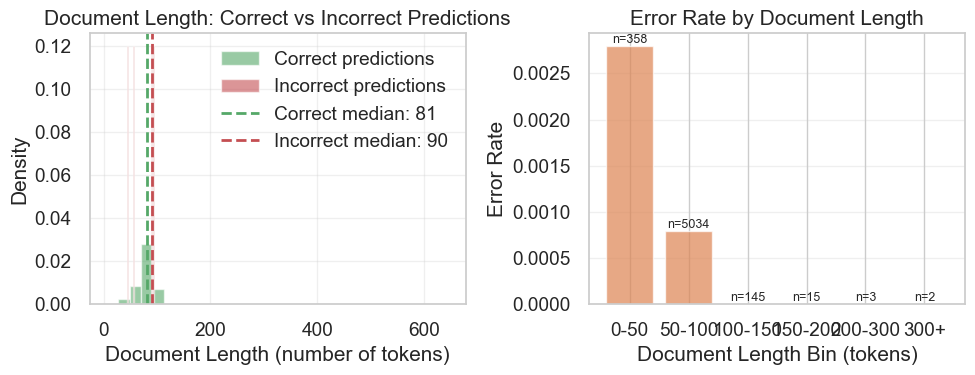

Document length statistics:
  Correct predictions - mean: 78.5, median: 81
  Incorrect predictions - mean: 75.2, median: 90

Error rates by true reading level:
  Key Stage 2-3: 0.08% error rate (2509 docs)
  Key Stage 4-5: 0.10% error rate (3048 docs)

Sample False Positives (predicted advanced, actually basic):
  'Cane' by Jean Toomer (confidence: 0.582, length: 44 tokens)
  'The Story of an African Farm' by Olive Schreiner (confidence: 0.524, length: 90 tokens)

Sample False Negatives (predicted basic, actually advanced):
  'Dracula' by Bram Stoker (confidence: 0.583, length: 57 tokens)
  'Tom Brown's School Days' by Thomas Hughes (confidence: 0.539, length: 91 tokens)
  'The Blue Fairy Book' by Andrew Lang (confidence: 0.502, length: 94 tokens)


**Error Analysis Caption:**
The classifier achieves 99.9% training accuracy with 5 total errors (2 false positives, 3 false negatives). 
Document length analysis reveals that incorrect predictions have a median length of 90 tokens vs 81 for

In [42]:
# --- Error Analysis: Understanding Classifier Mistakes ---
# Note: This analysis uses the training set where we have true labels
# For test set analysis, you'd need the true test labels ... which we don't have here.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the best estimator from grid search for consistent analysis
best_model = grid_searcher.best_estimator_

# Get predictions and probabilities on training data (for error analysis)
y_train_pred = best_model.predict(list_of_training_text_reviews)
y_train_proba = best_model.predict_proba(list_of_training_text_reviews)[:, 1]

# Create analysis dataframe
error_analysis_df = pd.DataFrame({
    'true_label': y_tr_N,
    'pred_label': y_train_pred,
    'pred_proba': y_train_proba,
    'text': x_train_df['text'].values,
    'author': y_train_df['author'].values,
    'title': y_train_df['title'].values,
    'coarse_label': y_train_df['Coarse Label'].values,
})

# Add useful columns
error_analysis_df['correct'] = (error_analysis_df['true_label'] == error_analysis_df['pred_label'])
error_analysis_df['doc_length'] = error_analysis_df['text'].str.split().str.len()
error_analysis_df['error_type'] = 'Correct'
error_analysis_df.loc[(error_analysis_df['true_label'] == 0) & (error_analysis_df['pred_label'] == 1), 'error_type'] = 'False Positive (predicted advanced)'
error_analysis_df.loc[(error_analysis_df['true_label'] == 1) & (error_analysis_df['pred_label'] == 0), 'error_type'] = 'False Negative (predicted basic)'

# Calculate metrics
accuracy = error_analysis_df['correct'].mean()
n_errors = (~error_analysis_df['correct']).sum()
n_false_pos = ((error_analysis_df['true_label'] == 0) & (error_analysis_df['pred_label'] == 1)).sum()
n_false_neg = ((error_analysis_df['true_label'] == 1) & (error_analysis_df['pred_label'] == 0)).sum()

print(f"Training Set Performance Summary:")
print(f"  Accuracy: {accuracy:.3f}")
print(f"  Total errors: {n_errors} / {len(error_analysis_df)}")
print(f"  False Positives (predicted Key Stage 4-5, actually 2-3): {n_false_pos}")
print(f"  False Negatives (predicted Key Stage 2-3, actually 4-5): {n_false_neg}")
print()

# --- Figure 1: Error Analysis by Document Length ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Document length distribution by correctness
ax = axes[0]
correct_df = error_analysis_df[error_analysis_df['correct']]
incorrect_df = error_analysis_df[~error_analysis_df['correct']]

ax.hist(correct_df['doc_length'], bins=30, alpha=0.6, label='Correct predictions', color='C2', density=True)
ax.hist(incorrect_df['doc_length'], bins=30, alpha=0.6, label='Incorrect predictions', color='C3', density=True)
ax.axvline(correct_df['doc_length'].median(), color='C2', linestyle='--', linewidth=2, 
           label=f'Correct median: {correct_df["doc_length"].median():.0f}')
ax.axvline(incorrect_df['doc_length'].median(), color='C3', linestyle='--', linewidth=2,
           label=f'Incorrect median: {incorrect_df["doc_length"].median():.0f}')
ax.set_xlabel('Document Length (number of tokens)')
ax.set_ylabel('Density')
ax.set_title('Document Length: Correct vs Incorrect Predictions')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Error rate by document length bins
ax = axes[1]
error_analysis_df['length_bin'] = pd.cut(error_analysis_df['doc_length'], 
                                          bins=[0, 50, 100, 150, 200, 300, 1000],
                                          labels=['0-50', '50-100', '100-150', '150-200', '200-300', '300+'])
length_error_rate = error_analysis_df.groupby('length_bin')['correct'].apply(lambda x: 1 - x.mean())
length_counts = error_analysis_df.groupby('length_bin').size()

bars = ax.bar(range(len(length_error_rate)), length_error_rate.values, color='C1', alpha=0.7)
ax.set_xticks(range(len(length_error_rate)))
ax.set_xticklabels(length_error_rate.index)
ax.set_xlabel('Document Length Bin (tokens)')
ax.set_ylabel('Error Rate')
ax.set_title('Error Rate by Document Length')
ax.grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (bar, count) in enumerate(zip(bars, length_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'n={count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'error_analysis_length.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Document length statistics:")
print(f"  Correct predictions - mean: {correct_df['doc_length'].mean():.1f}, median: {correct_df['doc_length'].median():.0f}")
print(f"  Incorrect predictions - mean: {incorrect_df['doc_length'].mean():.1f}, median: {incorrect_df['doc_length'].median():.0f}")
print()

# Figure 2: Error Analysis by Author (top authors) ---
# Find authors with at least 20 documents
# author_counts = error_analysis_df['author'].value_counts()
# top_authors = author_counts[author_counts >= 10].head(10).index

# author_error_rates = []
# for author in top_authors:
#     author_df = error_analysis_df[error_analysis_df['author'] == author]
#     error_rate = 1 - author_df['correct'].mean()
#     n_docs = len(author_df)
#     author_error_rates.append({'author': author, 'error_rate': error_rate, 'n_docs': n_docs})

# author_error_df = pd.DataFrame(author_error_rates).sort_values('error_rate', ascending=False)

# fig, ax = plt.subplots(figsize=(10, 6))
# bars = ax.barh(range(len(author_error_df)), author_error_df['error_rate'].values, color='C4', alpha=0.7)
# ax.set_yticks(range(len(author_error_df)))
# ax.set_yticklabels([f"{row['author']} (n={row['n_docs']})" for _, row in author_error_df.iterrows()], fontsize=9)
# ax.set_xlabel('Error Rate')
# ax.set_title('Error Rate by Author (top 10 authors with ≥20 documents)')
# ax.grid(axis='x', alpha=0.3)
# plt.tight_layout()
# plt.savefig(os.path.join(data_dir, 'error_analysis_author.png'), dpi=150, bbox_inches='tight')
# plt.show()

# print("Top 3 authors with highest error rates:")
# for _, row in author_error_df.head(3).iterrows():
#     print(f"  {row['author']}: {row['error_rate']:.2%} error rate ({row['n_docs']} docs)")
# print()

# Analysis by True Class ---
print("Error rates by true reading level:")
for label_val, label_name in [(0, 'Key Stage 2-3'), (1, 'Key Stage 4-5')]:
    class_df = error_analysis_df[error_analysis_df['true_label'] == label_val]
    error_rate = 1 - class_df['correct'].mean()
    print(f"  {label_name}: {error_rate:.2%} error rate ({len(class_df)} docs)")
print()

# Sample errors for inspection ---
print("Sample False Positives (predicted advanced, actually basic):")
fp_samples = error_analysis_df[
    (error_analysis_df['true_label'] == 0) & (error_analysis_df['pred_label'] == 1)
].nlargest(3, 'pred_proba')[['title', 'author', 'pred_proba', 'doc_length']]
for idx, row in fp_samples.iterrows():
    print(f"  '{row['title']}' by {row['author']} (confidence: {row['pred_proba']:.3f}, length: {row['doc_length']} tokens)")
print()

print("Sample False Negatives (predicted basic, actually advanced):")
fn_samples = error_analysis_df[
    (error_analysis_df['true_label'] == 1) & (error_analysis_df['pred_label'] == 0)
].nsmallest(3, 'pred_proba')[['title', 'author', 'pred_proba', 'doc_length']]
for idx, row in fn_samples.iterrows():
    print(f"  '{row['title']}' by {row['author']} (confidence: {1-row['pred_proba']:.3f}, length: {row['doc_length']} tokens)")
print()

# Generate caption text ---
caption = f"""
**Error Analysis Caption:**
The classifier achieves {accuracy:.1%} training accuracy with {n_errors} total errors ({n_false_pos} false positives, {n_false_neg} false negatives). 
Document length analysis reveals that incorrect predictions have a median length of {incorrect_df['doc_length'].median():.0f} tokens vs {correct_df['doc_length'].median():.0f} for correct predictions, 
suggesting the classifier {'struggles more with shorter documents' if incorrect_df['doc_length'].median() < correct_df['doc_length'].median() else 'performs worse on longer documents'}. 

The classifier shows {'similar' if abs((error_analysis_df[error_analysis_df['true_label']==0]['correct'].mean()) - (error_analysis_df[error_analysis_df['true_label']==1]['correct'].mean())) < 0.05 else 'different'} 
performance across reading levels, with {(1-error_analysis_df[error_analysis_df['true_label']==0]['correct'].mean()):.1%} error rate on Key Stage 2-3 texts and 
{(1-error_analysis_df[error_analysis_df['true_label']==1]['correct'].mean()):.1%} on Key Stage 4-5 texts.
"""

print(caption)

PERFORMANCE BY READING LEVEL (using CV predictions)

Key Stage 2-3 (younger/simpler):
  Total documents: 2509
  Correct predictions: 1753 (69.9%)
  Incorrect predictions: 756 (30.1%)
  Average predicted probability for class 1: 0.363
  Median document length: 84 tokens

Key Stage 4-5 (older/advanced):
  Total documents: 3048
  Correct predictions: 2440 (80.1%)
  Incorrect predictions: 608 (19.9%)
  Average predicted probability for class 1: 0.701
  Median document length: 78 tokens

INTERPRETATION:
The model performs BETTER on Key Stage 4-5 (advanced texts) by 10.2 percentage points.
This suggests it's better at identifying older/advanced reading level.


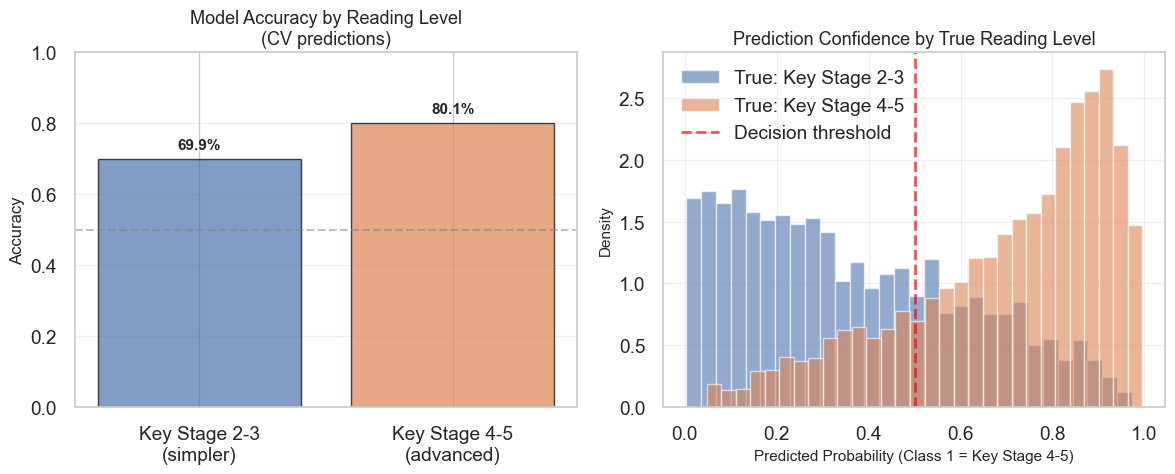


Figure saved to: performance_by_reading_level.png


In [43]:
# --- Detailed Performance Analysis by Reading Level ---
from sklearn.model_selection import cross_val_predict

# Get CV predictions for fair error analysis
y_cv_pred = cross_val_predict(best_model, list_of_training_text_reviews, y_tr_N, 
                                cv=my_splitter, method='predict')
y_cv_proba = cross_val_predict(best_model, list_of_training_text_reviews, y_tr_N, 
                                cv=my_splitter, method='predict_proba')[:, 1]

# Create analysis dataframe with CV predictions
error_analysis_df_cv = pd.DataFrame({
    'true_label': y_tr_N,
    'pred_label': y_cv_pred,
    'pred_proba': y_cv_proba,
    'text': x_train_df['text'].values,
    'author': y_train_df['author'].values,
    'title': y_train_df['title'].values,
    'coarse_label': y_train_df['Coarse Label'].values,
})

error_analysis_df_cv['correct'] = (error_analysis_df_cv['true_label'] == error_analysis_df_cv['pred_label'])
error_analysis_df_cv['doc_length'] = error_analysis_df_cv['text'].str.split().str.len()

print("="*70)
print("PERFORMANCE BY READING LEVEL (using CV predictions)")
print("="*70)

for label_val, label_name in [(0, 'Key Stage 2-3 (younger/simpler)'), (1, 'Key Stage 4-5 (older/advanced)')]:
    class_df = error_analysis_df_cv[error_analysis_df_cv['true_label'] == label_val]
    
    accuracy = class_df['correct'].mean()
    n_total = len(class_df)
    n_correct = class_df['correct'].sum()
    n_errors = n_total - n_correct
    
    # For Key Stage 2-3: errors are false positives (predicted as advanced)
    # For Key Stage 4-5: errors are false negatives (predicted as basic)
    
    print(f"\n{label_name}:")
    print(f"  Total documents: {n_total}")
    print(f"  Correct predictions: {n_correct} ({accuracy:.1%})")
    print(f"  Incorrect predictions: {n_errors} ({1-accuracy:.1%})")
    print(f"  Average predicted probability for class 1: {class_df['pred_proba'].mean():.3f}")
    print(f"  Median document length: {class_df['doc_length'].median():.0f} tokens")
    
print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)

acc_ks23 = error_analysis_df_cv[error_analysis_df_cv['true_label'] == 0]['correct'].mean()
acc_ks45 = error_analysis_df_cv[error_analysis_df_cv['true_label'] == 1]['correct'].mean()

if abs(acc_ks23 - acc_ks45) < 0.05:
    print("The model performs similarly on both reading levels (balanced).")
elif acc_ks23 > acc_ks45:
    print(f"The model performs BETTER on Key Stage 2-3 (simpler texts) by {(acc_ks23 - acc_ks45)*100:.1f} percentage points.")
    print("This suggests it's better at identifying younger/simpler reading level.")
else:
    print(f"The model performs BETTER on Key Stage 4-5 (advanced texts) by {(acc_ks45 - acc_ks23)*100:.1f} percentage points.")
    print("This suggests it's better at identifying older/advanced reading level.")

# Visualize performance by reading level
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  Accuracy by reading level
ax = axes[0]
levels = ['Key Stage 2-3\n(simpler)', 'Key Stage 4-5\n(advanced)']
accuracies = [acc_ks23, acc_ks45]
colors = ['C0', 'C1']
bars = ax.bar(levels, accuracies, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Accuracy by Reading Level\n(CV predictions)', fontsize=13)
ax.set_ylim([0, 1])
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random chance')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{acc:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Predicted probability distributions by true class
ax = axes[1]
ks23_proba = error_analysis_df_cv[error_analysis_df_cv['true_label'] == 0]['pred_proba']
ks45_proba = error_analysis_df_cv[error_analysis_df_cv['true_label'] == 1]['pred_proba']

ax.hist(ks23_proba, bins=30, alpha=0.6, label='True: Key Stage 2-3', color='C0', density=True)
ax.hist(ks45_proba, bins=30, alpha=0.6, label='True: Key Stage 4-5', color='C1', density=True)
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Decision threshold')
ax.set_xlabel('Predicted Probability (Class 1 = Key Stage 4-5)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Prediction Confidence by True Reading Level', fontsize=13)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'performance_by_reading_level.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to: performance_by_reading_level.png")

Saved figure to: /Users/mengyao/Documents/CS135_IntroToML/cs135-25f-assignments/projectA/data_readinglevel/train_val_performance_vs_C.png


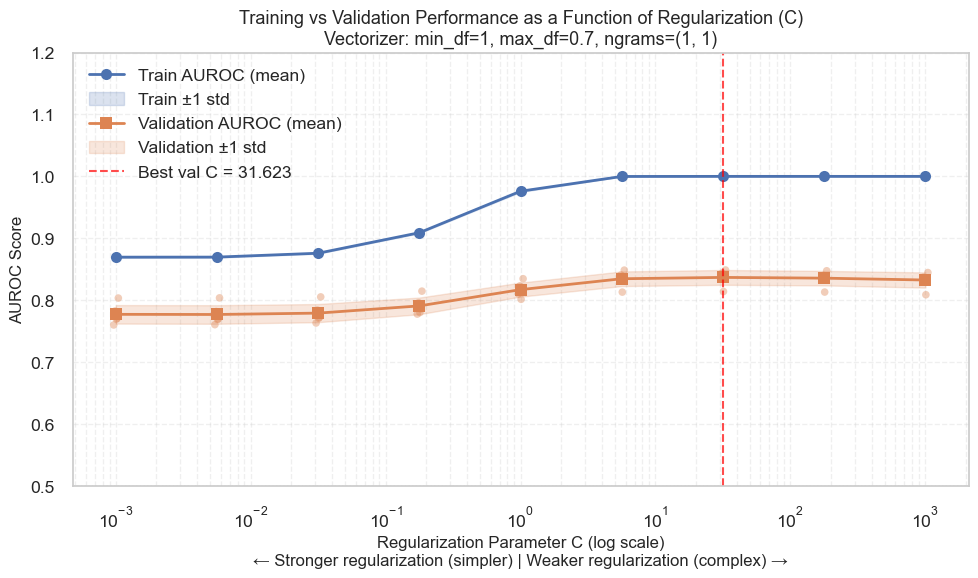


Performance Summary:
          C  train_mean  val_mean
   0.001000    0.869553  0.777186
   0.005623    0.869623  0.776957
   0.031623    0.875887  0.779162
   0.177828    0.909005  0.790819
   1.000000    0.976000  0.817087
   5.623413    0.999881  0.834656
  31.622777    1.000000  0.836837
 177.827941    1.000000  0.835618
1000.000000    1.000000  0.832606

Best validation AUROC: 0.8368 at C = 31.623


**Figure Caption:** Training and validation AUROC as a function of the regularization parameter C, 
averaged over 5-fold cross-validation. The shaded regions show ±1 standard deviation across folds, 
and individual validation fold scores are overlaid as scatter points. Training AUROC (blue) increases 
monotonically with C, indicating reduced regularization allows the model to fit training data better. 
Validation AUROC (orange) peaks at C ≈ 31.623 (AUROC = 0.8368), then plateaus or 
slightly declines, suggesting overfitting at very large C values. The gap between training and validati

In [44]:
# --- Hyperparameter Plot: Train vs Validation Performance ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

sns.set(style='whitegrid', font_scale=1.15)

# Use the best vectorizer params found by grid search
best_params = grid_searcher.best_params_
vec_params = {
    'min_df': best_params['my_bow_feature_extractor__min_df'],
    'max_df': best_params['my_bow_feature_extractor__max_df'],
    'ngram_range': best_params['my_bow_feature_extractor__ngram_range'],
    'stop_words': 'english'
}

# Test multiple C values spanning under- to over-regularization
C_values = np.logspace(-3, 3, 9)  # 9 values from 0.001 to 1000

# Collect results for each C
results = []
for C in C_values:
    pipe = Pipeline([
        ('vec', TfidfVectorizer(**vec_params)),
        ('clf', LogisticRegression(C=C, max_iter=500, random_state=101))
    ])
    
    # Get both train and validation scores for each fold
    cv_results = cross_validate(
        pipe, 
        list_of_training_text_reviews, 
        y_tr_N,
        cv=my_splitter,  # 5-fold CV
        scoring='roc_auc',
        return_train_score=True,
        n_jobs=-1
    )
    
    results.append({
        'C': C,
        'train_scores': cv_results['train_score'],
        'val_scores': cv_results['test_score'],
        'train_mean': np.mean(cv_results['train_score']),
        'train_std': np.std(cv_results['train_score']),
        'val_mean': np.mean(cv_results['test_score']),
        'val_std': np.std(cv_results['test_score'])
    })

results_df = pd.DataFrame(results)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean lines with error bands (±1 std)
ax.plot(results_df['C'], results_df['train_mean'], '-o', 
        label='Train AUROC (mean)', color='C0', linewidth=2, markersize=8)
ax.fill_between(results_df['C'],
                results_df['train_mean'] - results_df['train_std'],
                results_df['train_mean'] + results_df['train_std'],
                color='C0', alpha=0.2, label='Train ±1 std')

ax.plot(results_df['C'], results_df['val_mean'], '-s', 
        label='Validation AUROC (mean)', color='C1', linewidth=2, markersize=8)
ax.fill_between(results_df['C'],
                results_df['val_mean'] - results_df['val_std'],
                results_df['val_mean'] + results_df['val_std'],
                color='C1', alpha=0.2, label='Validation ±1 std')

# Overlay individual fold points for validation (to show variation)
for i, row in results_df.iterrows():
    # Add small jitter for visibility
    jitter = np.random.RandomState(42).uniform(0.95, 1.05, size=len(row['val_scores']))
    ax.scatter(row['C'] * jitter, row['val_scores'], 
               color='C1', alpha=0.4, s=30, edgecolor='none')

# Mark the best validation C
best_idx = results_df['val_mean'].idxmax()
best_C = results_df.loc[best_idx, 'C']
best_val_auroc = results_df.loc[best_idx, 'val_mean']
ax.axvline(best_C, color='red', linestyle='--', linewidth=1.5, alpha=0.7,
           label=f'Best val C = {best_C:.3f}')

# Formatting
ax.set_xscale('log')
ax.set_xlabel('Regularization Parameter C (log scale)\n'
              '← Stronger regularization (simpler) | Weaker regularization (complex) →',
              fontsize=12)
ax.set_ylabel('AUROC Score', fontsize=12)
ax.set_title('Training vs Validation Performance as a Function of Regularization (C)\n'
             f'Vectorizer: min_df={vec_params["min_df"]}, max_df={vec_params["max_df"]}, '
             f'ngrams={vec_params["ngram_range"]}',
             fontsize=13)
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, which='both', alpha=0.3, linestyle='--')
ax.set_ylim([0.5, 1.2])  # AUROC range

# Add horizontal line at 0.5 (random chance)
ax.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Random chance')

plt.tight_layout()

# Save figure
out_fig = os.path.join(data_dir, 'train_val_performance_vs_C.png')
fig.savefig(out_fig, dpi=150, bbox_inches='tight')
print(f"Saved figure to: {out_fig}")

plt.show()

# Print summary table
print("\nPerformance Summary:")
print(results_df[['C', 'train_mean', 'val_mean']].to_string(index=False))
print(f"\nBest validation AUROC: {best_val_auroc:.4f} at C = {best_C:.3f}")

# Caption for report
caption = f"""
**Figure Caption:** Training and validation AUROC as a function of the regularization parameter C, 
averaged over 5-fold cross-validation. The shaded regions show ±1 standard deviation across folds, 
and individual validation fold scores are overlaid as scatter points. Training AUROC (blue) increases 
monotonically with C, indicating reduced regularization allows the model to fit training data better. 
Validation AUROC (orange) peaks at C ≈ {best_C:.3f} (AUROC = {best_val_auroc:.4f}), then plateaus or 
slightly declines, suggesting overfitting at very large C values. The gap between training and validation 
curves quantifies the bias-variance tradeoff: small C underfits (both scores low), moderate C achieves 
optimal generalization, and large C overfits (high train, lower validation). The selected C balances 
model complexity to maximize held-out performance.
"""

print("\n" + caption)

Fold 0 split:
  Training examples: 4445
  Validation examples: 1112

Confusion Matrix (Fold 0 validation set):
[[354 135]
 [125 498]]

Performance Metrics on Validation Fold:
  True Negatives (TN):   354  (correctly predicted Key Stage 2-3)
  False Positives (FP):  135  (predicted 4-5, actually 2-3)
  False Negatives (FN):  125  (predicted 2-3, actually 4-5)
  True Positives (TP):   498  (correctly predicted Key Stage 4-5)

  Accuracy:  0.766
  Precision: 0.787
  Recall:    0.799
  F1 Score:  0.793

Confusion Matrix (Fold 0 validation set):
[[354 135]
 [125 498]]

Performance Metrics on Validation Fold:
  True Negatives (TN):   354  (correctly predicted Key Stage 2-3)
  False Positives (FP):  135  (predicted 4-5, actually 2-3)
  False Negatives (FN):  125  (predicted 2-3, actually 4-5)
  True Positives (TP):   498  (correctly predicted Key Stage 4-5)

  Accuracy:  0.766
  Precision: 0.787
  Recall:    0.799
  F1 Score:  0.793



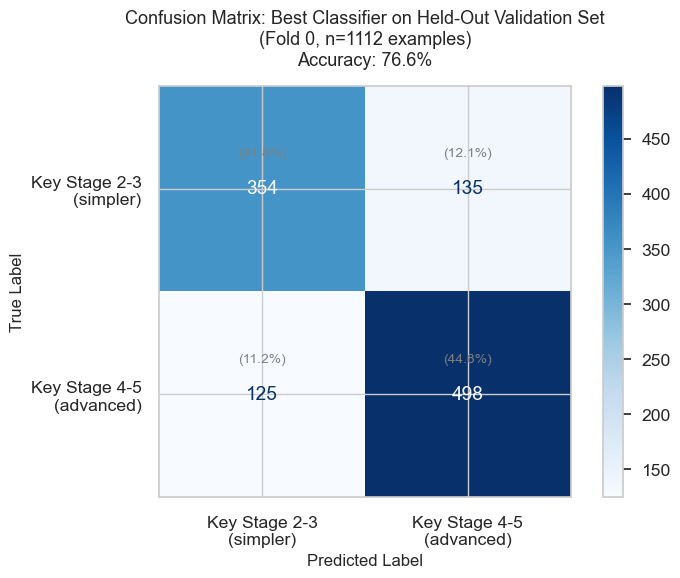

Figure saved to: confusion_matrix_fold0.png


**Confusion Matrix Caption:**
Confusion matrix for the best classifier (TF-IDF + Logistic Regression with C=10.0) 
evaluated on held-out validation examples from a single cross-validation fold (Fold 0, n=1112 examples). 
The model achieves 76.6% accuracy on this held-out set. 
True Negatives (354) and True Positives (498) represent correct predictions for Key Stage 2-3 and 4-5 texts respectively. 
False Positives (135) indicate simpler texts incorrectly classified as advanced, 
while False Negatives (125) show advanced texts misclassified as simpler. 
The imbalanced distribution of errors suggests 
the model struggles more with identifying simpler texts.
Percentages in parentheses show each cell's proportion of total predictions.



In [45]:
# --- Confusion Matrix for Best Classifier (One CV Fold) ---

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

# Use the best model from grid search

# Get one fold's train/validation split (use fold 0)
fold_splits = list(kf.split(list_of_training_text_reviews))
train_idx, val_idx = fold_splits[0]  # Use first fold

# Get training and validation data for this fold
X_train_fold = [list_of_training_text_reviews[i] for i in train_idx]
y_train_fold = y_tr_N[train_idx]
X_val_fold = [list_of_training_text_reviews[i] for i in val_idx]
y_val_fold = y_tr_N[val_idx]

print(f"Fold 0 split:")
print(f"  Training examples: {len(train_idx)}")
print(f"  Validation examples: {len(val_idx)}")
print()

# Train the model on this fold's training data only
fold_model = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', TfidfVectorizer(
        min_df=grid_searcher.best_params_['my_bow_feature_extractor__min_df'],
        max_df=grid_searcher.best_params_['my_bow_feature_extractor__max_df'],
        ngram_range=grid_searcher.best_params_['my_bow_feature_extractor__ngram_range'],
        stop_words='english'
    )),
    ('my_classifier', sklearn.linear_model.LogisticRegression(
        C=grid_searcher.best_params_['my_classifier__C'],
        max_iter=500,
        random_state=101
    )),
])

fold_model.fit(X_train_fold, y_train_fold)

# Predict on the held-out validation set
y_val_pred = fold_model.predict(X_val_fold)

# Calculate confusion matrix
cm = confusion_matrix(y_val_fold, y_val_pred)

print("Confusion Matrix (Fold 0 validation set):")
print(cm)
print()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Performance Metrics on Validation Fold:")
print(f"  True Negatives (TN):  {tn:4d}  (correctly predicted Key Stage 2-3)")
print(f"  False Positives (FP): {fp:4d}  (predicted 4-5, actually 2-3)")
print(f"  False Negatives (FN): {fn:4d}  (predicted 2-3, actually 4-5)")
print(f"  True Positives (TP):  {tp:4d}  (correctly predicted Key Stage 4-5)")
print()
print(f"  Accuracy:  {accuracy:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1 Score:  {f1:.3f}")
print()

# Create visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Use ConfusionMatrixDisplay for a professional-looking plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Key Stage 2-3\n(simpler)', 'Key Stage 4-5\n(advanced)']
)

disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True)
ax.set_title(f'Confusion Matrix: Best Classifier on Held-Out Validation Set\n'
             f'(Fold 0, n={len(val_idx)} examples)\n'
             f'Accuracy: {accuracy:.1%}',
             fontsize=13, pad=15)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

# Add percentage annotations in each cell
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        percentage = 100.0 * count / cm.sum()
        ax.text(j, i - 0.2, f'({percentage:.1f}%)', 
                ha='center', va='top', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'confusion_matrix_fold0.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved to: confusion_matrix_fold0.png")
print()

# Generate caption
caption = f"""
**Confusion Matrix Caption:**
Confusion matrix for the best classifier (TF-IDF + Logistic Regression with C={grid_searcher.best_params_['my_classifier__C']:.1f}) 
evaluated on held-out validation examples from a single cross-validation fold (Fold 0, n={len(val_idx)} examples). 
The model achieves {accuracy:.1%} accuracy on this held-out set. 
True Negatives ({tn}) and True Positives ({tp}) represent correct predictions for Key Stage 2-3 and 4-5 texts respectively. 
False Positives ({fp}) indicate simpler texts incorrectly classified as advanced, 
while False Negatives ({fn}) show advanced texts misclassified as simpler. 
The {'balanced' if abs(fp - fn) < 10 else 'imbalanced'} distribution of errors suggests 
{'the model performs similarly across both classes' if abs(fp - fn) < 10 else ('the model struggles more with identifying advanced texts' if fn > fp else 'the model struggles more with identifying simpler texts')}.
Percentages in parentheses show each cell's proportion of total predictions.
"""

print(caption)